Exploring cardiovascular disease database from Kaggle:

https://www.kaggle.com/sulianova/cardiovascular-disease-dataset


In [4]:
!pip install seaborn==0.9.0
from sqlalchemy import create_engine
#import pandas and read in out GDrive-mounted csv
import pandas as pd
from scipy import stats
import seaborn as sns 
sns.set()
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from numpy import mean, std
from statsmodels.stats.proportion import proportions_ztest
import math
from math import sqrt
import matplotlib.pyplot as plt
from google.colab import drive
import sys
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


Lets preview the data

In [5]:
heart_df = pd.read_csv('/content/gdrive/My Drive/Colab Datasets/cardio_train.csv')
heart_df.head() #preview data
                 

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [6]:
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
id             70000 non-null int64
age            70000 non-null int64
gender         70000 non-null int64
height         70000 non-null int64
weight         70000 non-null float64
ap_hi          70000 non-null int64
ap_lo          70000 non-null int64
cholesterol    70000 non-null int64
gluc           70000 non-null int64
smoke          70000 non-null int64
alco           70000 non-null int64
active         70000 non-null int64
cardio         70000 non-null int64
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [7]:
heart_df.isnull().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

Data contains no nulls in any of the coulmns

*   Change age from days to years
*   Height from cm to in
*   Weight from kg to lbs



In [8]:
heart_df.age = heart_df.age/365 #change age to years
heart_df.age = round(heart_df.age)
heart_df.head(2)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50.0,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55.0,1,156,85.0,140,90,3,1,0,0,1,1


In [9]:
heart_df.height = heart_df.height/2.54 #change cm to in
heart_df.height = round(heart_df.height)
heart_df.head(2)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50.0,2,66.0,62.0,110,80,1,1,0,0,1,0
1,1,55.0,1,61.0,85.0,140,90,3,1,0,0,1,1


In [10]:
heart_df.weight = heart_df.weight * 2.20462 #change kg to lbs
heart_df.weight = round(heart_df.weight)
heart_df.head(2)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50.0,2,66.0,137.0,110,80,1,1,0,0,1,0
1,1,55.0,1,61.0,187.0,140,90,3,1,0,0,1,1


Body Mass Index (BMI) measures a persons body fat based on thier height and weight.
* Formula: BMI = (Weight/(Height^2)) * 703

In [11]:
heart_df = heart_df.assign(bmi = (703 * heart_df.weight)/(heart_df.height**2)) 
heart_df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,0,50.0,2,66.0,137.0,110,80,1,1,0,0,1,0,22.109963
1,1,55.0,1,61.0,187.0,140,90,3,1,0,0,1,1,35.329481
2,2,52.0,1,65.0,141.0,130,70,3,1,0,0,0,1,23.461065
3,3,48.0,2,67.0,181.0,150,100,1,1,0,0,1,1,28.345511
4,4,48.0,1,61.0,123.0,100,60,1,1,0,0,0,0,23.238108


Lets look at the statistics on this data.

In [12]:
heart_df.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,53.338686,1.349571,64.741786,163.556686,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700,27.523477
std,28851.302323,6.765294,0.476838,3.278625,31.740294,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003,6.095963
min,0.000000,30.000000,1.000000,22.000000,22.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.443265
25%,25006.750000,48.000000,1.000000,63.000000,143.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,23.793846
50%,50001.500000,54.000000,1.000000,65.000000,159.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,26.309646
75%,74889.250000,58.000000,2.000000,67.000000,181.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,30.179293
max,99999.000000,65.000000,2.000000,98.000000,441.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,289.011111


A 22lb or 22in 30 year old doesn't sound correct. Lets clean up the data.
* Eliminate any heights and weights that fall outside of 97.5% of the data or 2.5% of the data.

In [13]:
heart_df.drop(heart_df[(heart_df['height'] > heart_df['height'].quantile(0.975)) | (heart_df['height'] < heart_df['height'].quantile(0.025))].index,inplace=True)
heart_df.drop(heart_df[(heart_df['weight'] > heart_df['weight'].quantile(0.975)) | (heart_df['weight'] < heart_df['weight'].quantile(0.025))].index,inplace=True)
heart_df.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
count,64436.000000,64436.000000,64436.000000,64436.000000,64436.000000,64436.000000,64436.000000,64436.000000,64436.000000,64436.000000,64436.000000,64436.000000,64436.000000,64436.000000
mean,49903.190980,53.356509,1.348035,64.790536,162.234620,128.836784,95.977233,1.360295,1.222748,0.086442,0.052952,0.803821,0.498898,27.229493
std,28837.689631,6.751185,0.476351,2.791933,26.011398,160.284858,185.794495,0.675588,0.568950,0.281018,0.223939,0.397109,0.500003,4.489693
min,0.000000,30.000000,1.000000,59.000000,115.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,16.037493
25%,24924.750000,48.000000,1.000000,63.000000,143.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,23.803965
50%,49907.000000,54.000000,1.000000,65.000000,159.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,26.306015
75%,74748.500000,58.000000,2.000000,67.000000,179.000000,140.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,29.917105
max,99999.000000,65.000000,2.000000,71.000000,236.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,47.661017


There also shouldn't be any negative values for ap_hi or ap_lo (blood pressures).
* Eliminate any ap_hi's and ap_low's that fall outside of 97.5% of the data or 2.5% of the data

In [14]:
heart_df.drop(heart_df[(heart_df['ap_hi'] > heart_df['ap_hi'].quantile(0.975)) | (heart_df['ap_hi'] < heart_df['ap_hi'].quantile(0.025))].index,inplace=True)
heart_df.drop(heart_df[(heart_df['ap_lo'] > heart_df['ap_lo'].quantile(0.975)) | (heart_df['ap_lo'] < heart_df['ap_lo'].quantile(0.025))].index,inplace=True)
heart_df.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
count,60695.000000,60695.000000,60695.000000,60695.000000,60695.000000,60695.000000,60695.000000,60695.000000,60695.000000,60695.000000,60695.000000,60695.000000,60695.000000,60695.000000
mean,49908.168284,53.345168,1.347656,64.814828,161.972156,125.820875,81.070022,1.352187,1.220150,0.085806,0.051965,0.803806,0.489019,27.164747
std,28841.631685,6.747557,0.476230,2.778448,25.767850,13.805339,8.252186,0.670886,0.567492,0.280080,0.221958,0.397120,0.499884,4.445994
min,0.000000,30.000000,1.000000,59.000000,115.000000,100.000000,60.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,16.037493
25%,24879.000000,48.000000,1.000000,63.000000,143.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,23.803965
50%,49930.000000,54.000000,1.000000,65.000000,159.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,26.254898
75%,74760.000000,58.000000,2.000000,67.000000,176.000000,135.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,29.809834
max,99999.000000,65.000000,2.000000,71.000000,236.000000,165.000000,100.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,47.661017


Next lets get some info on some of the categories

In [15]:
heart_df['cardio'].value_counts()

0    31014
1    29681
Name: cardio, dtype: int64

In [16]:
heart_df['gender'].value_counts()

1    39594
2    21101
Name: gender, dtype: int64

In [17]:
heart_df['smoke'].value_counts()

0    55487
1     5208
Name: smoke, dtype: int64

In [18]:
heart_df['alco'].value_counts()

0    57541
1     3154
Name: alco, dtype: int64

In [19]:
heart_df['cholesterol'].value_counts()

1    46054
2     7906
3     6735
Name: cholesterol, dtype: int64

In [20]:
heart_df['gluc'].value_counts()

1    51896
3     4563
2     4236
Name: gluc, dtype: int64

In [21]:
heart_df['active'].value_counts()

1    48787
0    11908
Name: active, dtype: int64

Lets look at the correlation of non-binary values

In [22]:
heart_df[['age','height','weight','ap_hi','ap_lo','bmi']].corr()

,age,height,weight,ap_hi,ap_lo,bmi
age,1.000000,-0.085626,0.061790,0.204159,0.146893,0.107706
height,-0.085626,1.000000,0.249657,-0.013585,0.004884,-0.290618
weight,0.061790,0.249657,1.000000,0.231482,0.211056,0.850507
ap_hi,0.204159,-0.013585,0.231482,1.000000,0.695888,0.234866
ap_lo,0.146893,0.004884,0.211056,0.695888,1.000000,0.204729
bmi,0.107706,-0.290618,0.850507,0.234866,0.204729,1.000000


Notable Correlations:
We may want to use these later in our hypothesis testing
* Age & BMI
* Weight & BMI 
* Height & Weight


Next lets use crosstabs to examine the binary data correlations with cardiovascuar disease.

In [23]:
pd.crosstab(heart_df['gluc'],heart_df['cardio'], normalize='columns').round(4)*100#make into percentages

cardio,0,1
gluc,,
1,88.47,82.41
2,5.82,8.19
3,5.71,9.40


In [24]:
pd.crosstab(heart_df['cholesterol'],heart_df['cardio'],normalize='columns').round(4)*100

cardio,0,1
cholesterol,,
1,84.25,67.13
2,10.50,15.67
3,5.26,17.20


In [25]:
pd.crosstab(heart_df['smoke'],heart_df['cardio'],normalize='columns').round(4)*100

cardio,0,1
smoke,,
0,90.76,92.11
1,9.24,7.89


In [26]:
pd.crosstab(heart_df['active'],heart_df['cardio'],normalize='columns').round(4)*100

cardio,0,1
active,,
0,18.11,21.2
1,81.89,78.8


In [27]:
pd.crosstab(heart_df['alco'],heart_df['cardio'],normalize='columns').round(4)*100

cardio,0,1
alco,,
0,94.48,95.14
1,5.52,4.86


Lets use distribution charts to see the distribution of height, age, and BMI.

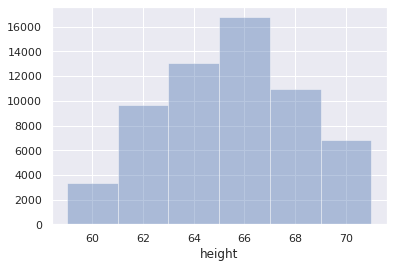

In [28]:
ax = sns.distplot(heart_df['height'], bins=6, kde=False) 

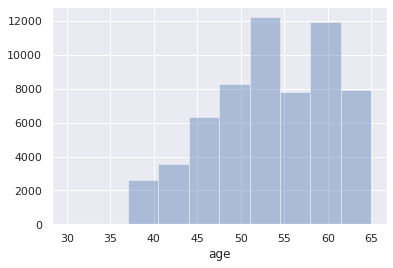

In [29]:
ax = sns.distplot(heart_df['age'], bins=10, kde=False)

Age is skewed highly to the right towards older people. We need to be careful when analysing with age or we will get inaccurate results.

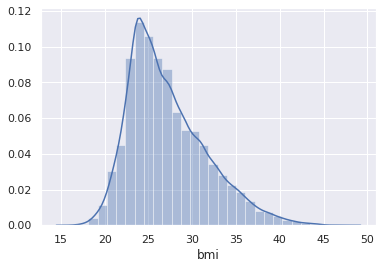

In [30]:
ax = sns.distplot(heart_df['bmi'], bins=30)

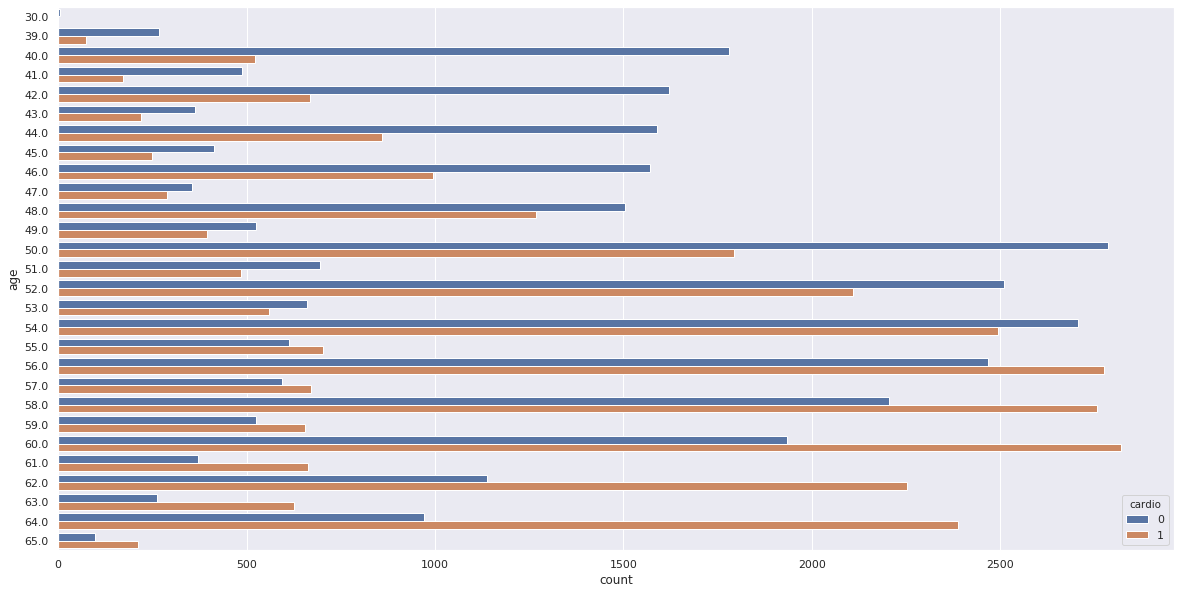

In [31]:
plt.figure(figsize=(20,10))
sns.countplot(y='age', hue='cardio', data=heart_df)

As age increases, cardiovascular disease increases. Starting at 55 the number of people with a cardiovascular disease exceeds the number of those that do not have a cardiovascular disease. But this study is heavly weighed toward older people.


The null hypothesis is that there is no significant difference in the number of people with cardiovascular disease based on BMI.

In [32]:
pos_cardio = heart_df.iloc[(heart_df['cardio'] == 1).values]
len(pos_cardio.index)

29681

In [33]:
neg_cardio = heart_df.iloc[(heart_df['cardio'] == 0).values]
len(neg_cardio.index)

31014

In [34]:
norm_weight_cardio = heart_df.iloc[((heart_df['bmi'] <= 25) & (heart_df['cardio'] == 1)).values]
len(norm_weight_cardio.index)

9442

In [35]:
overweight_cardio = heart_df.iloc[((heart_df['bmi'] > 25) & (heart_df['cardio'] == 1)).values]
len(overweight_cardio.index)#people having and not having cardio disease with > 25bmi

20239

In [36]:
overweight_no_cardio = heart_df.iloc[((heart_df['bmi'] > 25) & (heart_df['cardio'] == 0)).values]
len(overweight_no_cardio.index)#people having and not having cardio disease with > 25bmi

17029

In [37]:
stats.ttest_ind(overweight_cardio['bmi'],overweight_no_cardio['bmi'])

Ttest_indResult(statistic=24.557139691311047, pvalue=4.087598828199823e-132)

There is a difference of 24.56 standard deviations with a p-value < .05 indicating this relationship is significant

In [38]:

def get_95_ci(array_1, array_2):
    sample_1_n = array_1.shape[0]
    sample_2_n = array_2.shape[0]
    sample_1_mean = array_1.mean()
    sample_2_mean = array_2.mean()
    sample_1_var = array_1.var()
    sample_2_var = array_2.var()
    mean_difference = sample_2_mean - sample_1_mean
    std_err_difference = math.sqrt((sample_1_var/sample_1_n)+(sample_2_var/sample_2_n))
    margin_of_error = 1.96 * std_err_difference
    ci_lower = mean_difference - margin_of_error
    ci_upper = mean_difference + margin_of_error
    return("The difference in means at the 95% confidence interval (two-tail) is between "+str(ci_lower)+" and "+str(ci_upper)+".")

get_95_ci(norm_weight_cardio['bmi'],overweight_cardio['bmi'])

'The difference in means at the 95% confidence interval (two-tail) is between 6.85710525925167 and 6.977463196063445.'

In [39]:
def cohen_d(x,y):
  return (mean(x) - mean(y)) / sqrt((std(x, ddof=1) ** 2 + std(y, ddof=1) ** 2) / 2.0)
cohen_d(overweight_cardio['bmi'],norm_weight_cardio['bmi'])

2.3734514454442945

* Reject the null that there is no significant difference in the number of people with cardiovascular disease based on BMI.  
* The difference is significant at p < .05
* Oberve a very large significance with a cohen d of 2.37

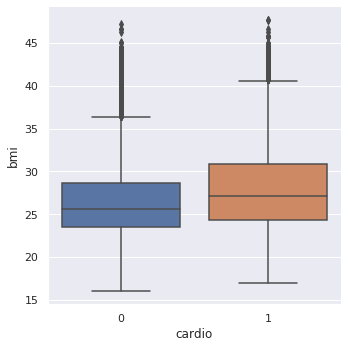

In [40]:
sns.catplot(y="bmi", x='cardio', kind='box', data=heart_df)

A lot of our results are binary instead of continuous so we will use the z-test. Lets write a function

In [0]:
def z_test(a1,b1,a2,b2):
  count = np.array([a1, b1]) 
  nobs = np.array([a2, b2])
  stat, pval = proportions_ztest(count, nobs)
  return(('p-value:''{0:0.3f}'.format(pval)), (stat))
#(a1=variable_1 w/ cardio, b1=variable_2 w/ cardio, a2=variable_1, b2=variable_2)

Lets also create a function that can give us the percentage of cardiovascular disease for each factor.  


In [0]:
def percent(a1,a2,b1,b2): #a1:factor 1 , a2: factor 1 with cardio, b1: factor 2, b2: factor 2 with cardio
  x = round((a2/a1)*100)
  y = round((b2/b1)*100)
  return('{}%,'.format(x) +' ' '{}%'.format(y))
  

The null hypothesis is that there is no significant difference in the number of people with cardiovascular disease based on cholesterol.

In [43]:
norm_cholesterol = heart_df.iloc[(heart_df['cholesterol'] == 1).values]
nc = len(norm_cholesterol.index)
print(nc)

46054


In [44]:
abnorm_cholesterol = heart_df.iloc[(heart_df['cholesterol'] > 1).values]
ac = len(abnorm_cholesterol.index)
print(ac)

14641


In [45]:
norm_cholesterol_cardio = heart_df.iloc[((heart_df['cholesterol'] == 1) & (heart_df['cardio'] == 1)).values]
ncc = len(norm_cholesterol_cardio.index)
print(ncc)

19925


In [46]:
abnorm_cholesterol_cardio = heart_df.iloc[((heart_df['cholesterol'] > 1) & (heart_df['cardio'] == 1)).values]
acc = len(abnorm_cholesterol_cardio.index)
print(acc)

9756


In [47]:
z_test(acc, ncc, ac, nc) #(abnrom_chol w/ cardio, norm_chol w/ cardio, abnorm_chol, norm_chol)

('p-value:0.000', 49.27683744459846)

Lets calculate the percent of those with heart disease that had a normal cholesterol and that had a abnormal cholesterol.

In [66]:
percent(nc,ncc,ac,acc)

'43%, 67%'

* Reject the null that there is no significant difference in the number of people with cardiovascular disease based on glucose.  
* The difference is significant at p < .05

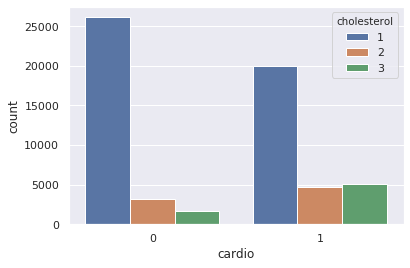

In [67]:
sns.countplot(x='cardio', hue='cholesterol', data=heart_df)

The null hypothesis is that there is no significant difference in the number of people with cardiovascular disease based on glucose.

In [69]:
norm_glucose = heart_df.iloc[(heart_df['gluc'] == 1).values]
ng = len(norm_glucose.index)
print(ng)

51896


In [70]:
abnorm_glucose = heart_df.iloc[(heart_df['gluc'] > 1).values]
ag = len(abnorm_glucose.index)
print(ag)

8799


In [71]:
norm_glucose_cardio = heart_df.iloc[((heart_df['gluc'] == 1) & (heart_df['cardio'] == 1)).values]
ngc = len(norm_glucose_cardio.index)
print(ngc)

24459


In [72]:
abnorm_glucose_cardio = heart_df.iloc[((heart_df['gluc'] > 1) & (heart_df['cardio'] == 1)).values]
agc = len(abnorm_glucose_cardio.index)
print(agc)

5222


In [73]:
z_test(agc,ngc,ag,ng)

('p-value:0.000', 21.198310764037345)

In [123]:
percent(ng,ngc,ag,agc)

'47%, 59%'

* Reject the null that there is no significant difference in the number of people with cardiovascular disease based on glucose.  
* The difference is significant at p < .05

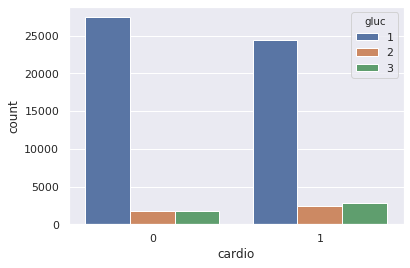

In [74]:
sns.countplot(x='cardio', hue='gluc', data=heart_df)

The null hypothesis is that there is no significant difference in the number of people with cardiovascular disease based on weather or not they are active.

In [75]:
active = heart_df.iloc[(heart_df['active'] == 1).values]
a = len(active.index)
print(a)

48787


In [76]:
not_active = heart_df.iloc[(heart_df['active'] == 0).values]
na = len(not_active.index)
print(na)

11908


In [77]:
active_cardio = heart_df.iloc[((heart_df['active'] == 1) & (heart_df['cardio'] == 1)).values]
ac = len(active_cardio.index)
print(ac)

23389


In [78]:
not_active_cardio = heart_df.iloc[((heart_df['active'] == 0) & (heart_df['cardio'] == 1)).values]
nac = len(not_active_cardio.index)
print(nac)

6292


In [79]:
z_test(nac,ac,na,a)

('p-value:0.000', 9.585028414845493)

* Reject the null that there is no significant difference in the number of people with cardiovascular disease based on weather or not they are active.  
* The difference is significant at p < .05

In [124]:
percent(a,ac,na,nac)

'48%, 53%'

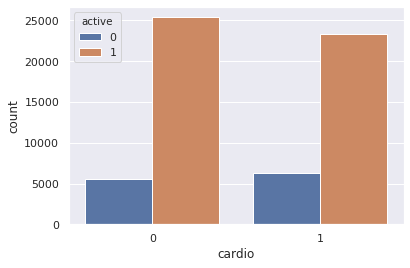

In [80]:
sns.countplot(x='cardio', hue='active', data=heart_df)

The null hypothesis is that there is no significant difference in the number of people with cardiovascular disease based on gender.



In [81]:
male = heart_df.iloc[(heart_df['gender'] == 2).values]
m = len(male.index)
print(m)

21101


In [82]:
female = heart_df.iloc[(heart_df['gender'] == 1).values]
f = len(female.index)
print(f)

39594


In [83]:
male_cardio = heart_df.iloc[((heart_df['gender'] == 2) & (heart_df['cardio'] == 1)).values]
mc = len(male_cardio.index)
print(mc)

10243


In [84]:
female_cardio = heart_df.iloc[((heart_df['gender'] == 1) & (heart_df['cardio'] == 1)).values]
fc = len(female_cardio.index)
print(fc)

19438


In [85]:
z_test(fc,mc,f,m)

('p-value:0.196', 1.2922308554466542)

In [125]:
percent(m,mc,f,fc)

'49%, 49%'

* Accept the null that there is no significant difference in people with cardiovascular disease based on gender.
* The difference is not significant at p = .20

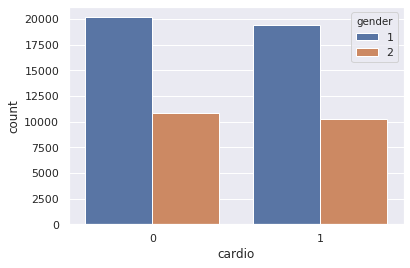

In [86]:
sns.countplot(x='cardio', hue='gender', data=heart_df)

A blood plessure of 130/80 is considered to have high blood pressure. The null hypothesis is that there is no significant difference in the number of people with cardiovascular disease based on blood pressure. 

In [87]:
abnorm_bp = heart_df.iloc[((heart_df['ap_hi'] > 130) & (heart_df['ap_lo'] > 80)).values]
abp = len(abnorm_bp.index)
print(abp)

11740


In [88]:
norm_bp = heart_df.iloc[((heart_df['ap_hi'] <= 130) & (heart_df['ap_lo'] <= 80)).values]
nbp = len(norm_bp.index)
print(nbp)

40453


In [89]:
abnorm_bp_cardio = heart_df.iloc[((heart_df['ap_hi'] > 130) & (heart_df['ap_lo'] > 80) & (heart_df['cardio'] == 1)).values]
abpc = len(abnorm_bp_cardio.index)
print(abpc)

9824


In [90]:
norm_bp_cardio = heart_df.iloc[((heart_df['ap_hi'] <= 130) & (heart_df['ap_lo'] <= 80) & (heart_df['cardio'] == 1)).values]
nbpc = len(norm_bp_cardio.index)
print(nbpc)

14142


In [91]:
z_test(abpc,nbpc,abp,nbp)

('p-value:0.000', 93.26063826170794)

In [126]:
percent(nbp,nbpc,abp,abpc)

'35%, 84%'

* Reject the null that there is no significant difference in the number of people with cardiovascular disease based on blood pressure.  
* The difference is significant at p < .05


The null hypothesis is there is no significant difference in cardiovascular disease in patients who have a high blood pressure and are active vs those with a high blood pressure and are not active.

In [92]:
abnorm_bp_active = heart_df.iloc[((heart_df['ap_hi'] > 130) & (heart_df['ap_lo'] > 80) & (heart_df['active'] == 1)).values]
abpa = len(abnorm_bp_active.index)
print(abpa)

9533


In [93]:
abnorm_bp_non_active = heart_df.iloc[((heart_df['ap_hi'] > 130) & (heart_df['ap_lo'] > 80) & (heart_df['active'] == 0)).values]
abpna = len(abnorm_bp_non_active.index)
print(abpna)

2207


In [94]:
abnorm_bp_active_cardio = heart_df.iloc[((heart_df['ap_hi'] > 130) & (heart_df['ap_lo'] > 80) & (heart_df['active'] == 1) & (heart_df['cardio'] == 1)).values]
abpac = len(abnorm_bp_active_cardio.index)
print(abpac)

7980


In [95]:
abnorm_bp_non_active_cardio = heart_df.iloc[((heart_df['ap_hi'] > 130) & (heart_df['ap_lo'] > 80) & (heart_df['active'] == 0) & (heart_df['cardio'] == 1)).values]
abpnac = len(abnorm_bp_non_active_cardio.index)
print(abpnac)

1844


In [96]:
z_test(abpnac,abpac,abpna,abpa)

('p-value:0.857', -0.17971956830376412)

In [127]:
percent(abpa,abpac,abpna,abpnac)

'84%, 84%'

* Accept the null that there is no significant difference in cardiovascular disease in patients who have a high blood pressure and are active vs those with a high blood pressure and are not active.
* The difference is not significant at p = .86

Next lets look at males and females that are overweight vs not overweight by comparing each one seperatley.

The null hypothesis is there is no significant difference in cardiovascular disease in males that are overweight and males that are not overweight.

In [97]:
male_overweight = heart_df.iloc[((heart_df['gender'] == 2) & (heart_df['bmi'] > 25)).values]
mo = len(male_overweight.index)
print(mo)

12117


In [98]:
male_normweight = heart_df.iloc[((heart_df['gender'] == 2) & (heart_df['bmi'] <= 25)).values]
mn = len(male_normweight.index)
print(mn)

8984


In [99]:
male_overweight_cardio = heart_df.iloc[((heart_df['gender'] == 2) & (heart_df['bmi'] > 25) & (heart_df['cardio'] == 1)).values]
moc = len(male_overweight_cardio.index)
print(moc)

6653


In [100]:
male_normweight_cardio = heart_df.iloc[((heart_df['gender'] == 2) & (heart_df['bmi'] <= 25) & (heart_df['cardio'] == 1)).values]
mnc = len(male_normweight_cardio.index)
print(mnc)

3590


Z-test of males that are overweight vs males that are not overweight

In [101]:
z_test(moc,mnc,mo,mn)

('p-value:0.000', 21.479891068891394)

In [128]:
percent(mn,mnc,mo,moc)

'40%, 55%'

* Reject the null that there is no significant difference in the number of people with cardiovascular disease in males that are overweight and males that are not overweight.  
* The difference is significant at p < .05

Now lets look at overweight females vs females that are not overweight. The null hypothesis is there is no significant difference in cardiovascular disease in females that are overweight and females that are not overweight.

In [102]:
female_overweight = heart_df.iloc[((heart_df['gender'] == 1) & (heart_df['bmi'] > 25)).values]
fo = len(female_overweight.index)
print(fo)

25151


In [103]:
female_normweight = heart_df.iloc[((heart_df['gender'] == 1) & (heart_df['bmi'] <= 25)).values]
fn = len(female_normweight.index)
print(fn)

14443


In [104]:
female_overweight_cardio = heart_df.iloc[((heart_df['gender'] == 1) & (heart_df['bmi'] > 25) & (heart_df['cardio'] == 1)).values]
foc = len(female_overweight_cardio.index)
print(foc)

13586


In [105]:
female_normweight_cardio = heart_df.iloc[((heart_df['gender'] == 1) & (heart_df['bmi'] <= 25) & (heart_df['cardio'] == 1)).values]
fnc = len(female_normweight_cardio.index)
print(fnc)

5852


Z-test of females that are overweight vs females that are not overweight

In [106]:
z_test(foc,fnc,fo,fn)

('p-value:0.000', 25.865538152413695)

In [129]:
percent(fn,fnc,fo,foc)

'41%, 54%'

* Reject the null that there is no significant difference in the number of people with cardiovascular disease in females that are overweight and females that are not overweight.  
* The difference is significant at p < .05
* Overweight females have a higher significance of cardiovascular disease compared to overweight males

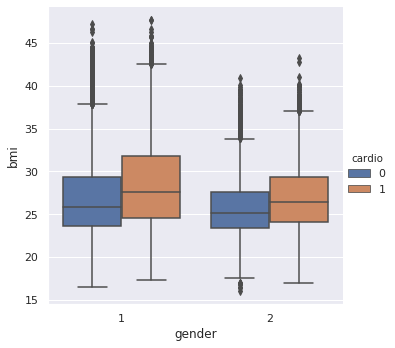

In [107]:
sns.catplot(y="bmi", x='gender', hue='cardio', kind='box', data=heart_df)

Null hypothesis is that there is no significant difference in cardiovascular disease in those older than 53 that are overweight vs not overweight.

In [108]:
older_abnorm_bmi = heart_df.iloc[((heart_df['age'] > 53) & (heart_df['bmi'] > 25)).values]
oab = len(older_abnorm_bmi.index)
print(oab)

21290


In [109]:
older_norm_bmi = heart_df.iloc[((heart_df['age'] > 53) & (heart_df['bmi'] <= 25)).values]
onb = len(older_norm_bmi.index)
print(onb)

11611


In [110]:
older_abnorm_bmi_cardio = heart_df.iloc[((heart_df['age'] > 53) & (heart_df['bmi'] > 25) & (heart_df['cardio'] == 1)).values]
oabc = len(older_abnorm_bmi_cardio.index)
print(oabc)

13171


In [111]:
older_norm_bmi_cardio = heart_df.iloc[((heart_df['age'] > 53) & (heart_df['bmi'] <= 25) & (heart_df['cardio'] == 1)).values]
onbc = len(older_norm_bmi_cardio.index)
print(onbc)

5848


In [112]:
z_test(oabc,onbc,oab,onb)

('p-value:0.000', 20.181610149167213)

In [130]:
percent(onb,onbc,oab,oabc)

'50%, 62%'

* Reject the null that there is no significant difference in the number of people with cardiovascular disease in those older than 53 that are overweight vs not overweight.  
* The difference is significant at p < .05

Null hypothesis is that there is no significant difference in cardiovascular disease in those older than 53 that have high cholesterol vs those that do not have a high cholesterol.

In [113]:
older_norm_chol = heart_df.iloc[((heart_df['age'] > 53) & (heart_df['cholesterol'] == 1)).values]
onc = len(older_norm_chol.index)
print(onc)

23584


In [114]:
older_abnorm_chol = heart_df.iloc[((heart_df['age'] > 53) & (heart_df['cholesterol'] > 1)).values]
oac = len(older_abnorm_chol.index)
print(oac)

9317


In [115]:
older_norm_chol_cardio = heart_df.iloc[((heart_df['age'] > 53) & (heart_df['cholesterol'] == 1) & (heart_df['cardio'] == 1)).values]
oncc = len(older_norm_chol_cardio.index)
print(oncc)

12419


In [116]:
older_abnorm_chol_cardio = heart_df.iloc[((heart_df['age'] > 53) & (heart_df['cholesterol'] > 1) & (heart_df['cardio'] == 1)).values]
oacc = len(older_abnorm_chol_cardio.index)
print(oacc)

6600


In [117]:
z_test(oacc,oncc,oac,onc)

('p-value:0.000', 30.082746207518035)

In [131]:
percent(onc,oncc,oac,oacc)

'53%, 71%'

* Reject the null hypothesis is that there is no significant difference in cardiovascular disease in those older than 53 that have high cholesterol vs those that do not have a high cholesterol.
* The differene is significant at p < .05

Null hypothesis is that there is no significant difference in cardiovascular disease in those older than 53 that have high glucose vs those that do not have a high glucose.

In [118]:
older_norm_gluc = heart_df.iloc[((heart_df['age'] > 53) & (heart_df['gluc'] == 1)).values]
ong = len(older_norm_gluc.index)
print(ong)

27341


In [119]:
older_abnorm_gluc = heart_df.iloc[((heart_df['age'] > 53) & (heart_df['gluc'] > 1)).values]
oag = len(older_abnorm_gluc.index)
print(oag)

5560


In [120]:
older_norm_gluc_cardio = heart_df.iloc[((heart_df['age'] > 53) & (heart_df['gluc'] == 1) & (heart_df['cardio'] == 1)).values]
ongc = len(older_norm_gluc_cardio.index)
print(ongc)

15398


In [121]:
older_abnorm_gluc_cardio = heart_df.iloc[((heart_df['age'] > 53) & (heart_df['gluc'] > 1) & (heart_df['cardio'] == 1)).values]
oagc = len(older_abnorm_gluc_cardio.index)
print(oagc)

3621


In [122]:
z_test(oagc,ongc,oag,ong)

('p-value:0.000', 12.122281872412282)

In [132]:
percent(ong,ongc,oag,oagc)

'56%, 65%'

* Reject the null hypothesis is that there is no significant difference in cardiovascular disease in those older than 53 that have high cholesterol vs those that do not have a high cholesterol.
* The differene is significant at p < .05

Based on the analysis of the heart disease database I was able to identify the highest risk factors of having a heart disease. 
* Single variables 

1.   High Blood Pressure
2.   BMI > 25
3.   High Cholesterol
4.   High Glucose



* Sets of variables

1. Overweight Females
2. Overweight Males
3. Pts over 53 with BMI > 25
4. Pts over 53 with high cholesterol
5. Pts over 53 with high glucose